<a href="https://colab.research.google.com/github/kamal-gavel/DSAlgo2025/blob/main/DQN_Agent_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2426598781.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


                 Close        High         Low        Open   Volume
Date                                                               
2020-01-01  646.518677  649.282536  642.745829  644.895492  2112415
2020-01-02  644.632324  649.984497  641.298181  648.317452  5658200
2020-01-03  654.547058  656.301876  643.930432  643.930432  7882938
2020-01-06  648.273560  661.390834  646.211670  654.634774  6519403
2020-01-07  638.665955  651.563822  636.209167  647.527763  7899363
Episode 1/10 | Final Portfolio Value: 10369.97 | Total Reward: 0.0389
Episode 2/10 | Final Portfolio Value: 10919.82 | Total Reward: 0.0890
Episode 3/10 | Final Portfolio Value: 10440.59 | Total Reward: 0.0436
Episode 4/10 | Final Portfolio Value: 10736.06 | Total Reward: 0.0823
Episode 5/10 | Final Portfolio Value: 8649.98 | Total Reward: -0.1243
Episode 6/10 | Final Portfolio Value: 13245.23 | Total Reward: 0.3234
Episode 7/10 | Final Portfolio Value: 12392.95 | Total Reward: 0.2381
Episode 8/10 | Final Portfolio Val

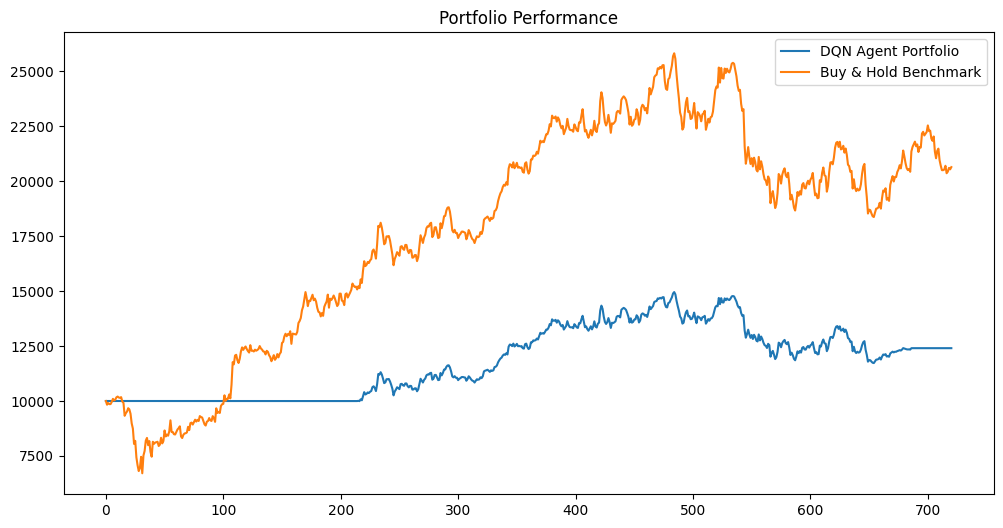

In [ ]:
# =====================================================
# Deep Q-Learning for Swing Trading & Portfolio Returns
# =====================================================

!pip install --upgrade scikit-learn

!pip install yfinance ta torch numpy pandas matplotlib scikit-learn --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------------
# 1. Load Stock Data (flattened)
# -----------------------------
import yfinance as yf
import pandas as pd

# Fetch raw stock data
df = yf.download("INFY.NS", start="2020-01-01", end="2023-01-01")

# If MultiIndex (second level like ('Adj Close','INFY.NS')), flatten it
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]  # Keep only first level

print(df.head())


# -----------------------------
# 2. Add Technical Indicators
# -----------------------------
import ta
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df = df.dropna().reset_index(drop=True)

# -----------------------------
# 3. Trading Environment
# -----------------------------
class TradingEnv:
    def __init__(self, df, initial_balance=10000):
        self.df = df
        self.n_steps = len(df)-1
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        self.prev_value = self.initial_balance
        self.done = False
        return self._get_state()

    def _get_state(self):
        row = self.df.iloc[self.current_step]
        return np.array([row['Close'], row['RSI'], row['MACD'], self.balance, self.position], dtype=np.float32)

    def step(self, action):
        """
        action = 0 (Hold), 1 (Buy), 2 (Sell)
        """
        row = self.df.iloc[self.current_step]
        price = row['Close']

        if action == 1:  # Buy
            if self.balance >= price:
                self.position += 1
                self.balance -= price
        elif action == 2:  # Sell
            if self.position > 0:
                self.position -= 1
                self.balance += price

        portfolio_value = self.balance + self.position * price

        # Reward = % change from previous value
        reward = (portfolio_value - self.prev_value) / self.prev_value
        self.prev_value = portfolio_value

        self.current_step += 1
        if self.current_step >= self.n_steps:
            self.done = True

        return self._get_state(), reward, self.done, {"portfolio_value": portfolio_value}

# -----------------------------
# 4. DQN Agent
# -----------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.memory = deque(maxlen=2000)
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q = self.model(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q * (1 - dones)

        loss = self.loss_fn(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -----------------------------
# 5. Train Agent
# -----------------------------
env = TradingEnv(df)
state_dim = len(env.reset())
action_dim = 3
agent = DQNAgent(state_dim, action_dim)

episodes = 10
portfolio_values = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    values = []
    while True:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        values.append(info["portfolio_value"])
        if done:
            portfolio_values.append(values)
            print(f"Episode {e+1}/{episodes} | Final Portfolio Value: {info['portfolio_value']:.2f} | Total Reward: {total_reward:.4f}")
            break

# -----------------------------
# 6. Performance Evaluation
# -----------------------------
# Last episode portfolio vs Buy & Hold
final_run = portfolio_values[-1]
buy_hold = df['Close'].values / df['Close'].values[0] * env.initial_balance


# RMSE (manual since 'squared' not available)
rmse = np.sqrt(mean_squared_error(buy_hold[:len(final_run)], final_run))

# MAE
mae = mean_absolute_error(buy_hold[:len(final_run)], final_run)

# MAPE
mape = np.mean(np.abs((buy_hold[:len(final_run)] - final_run) / buy_hold[:len(final_run)])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


# -----------------------------
# 7. Plot Portfolio Performance
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(final_run, label="DQN Agent Portfolio")
plt.plot(buy_hold[:len(final_run)], label="Buy & Hold Benchmark")
plt.legend()
plt.title("Portfolio Performance")
plt.show()
